<a href="https://colab.research.google.com/github/GergelyTuri/sleep/blob/master/notebooks/clustering/clustering_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!git clone https://github.com/GergelyTuri/sleep.git
%cd sleep
!pip install .

from google.colab import drive
drive.mount('/gdrive')

from os.path import join
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import numpy as np
import pandas as pd
import seaborn as sns
from sleep.src import google_drive
from sleep.src import clustering

useful_data = google_drive.useful_datasets()

Cloning into 'sleep'...
remote: Enumerating objects: 1009, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 1009 (delta 235), reused 273 (delta 160), pack-reused 625
Receiving objects: 100% (1009/1009), 18.91 MiB | 20.91 MiB/s, done.
Resolving deltas: 100% (597/597), done.
/content/sleep/sleep/sleep
Processing /content/sleep/sleep/sleep
  Preparing metadata (setup.py) ... done
  Created wheel for sleep: filename=sleep-0.11-py3-none-any.whl size=1011 sha256=255af1ee544be796e698b7c34db86ba50fc5d1d6bc1fcee46fa645d3af5a1ea2
  Stored in directory: /tmp/pip-ephem-wheel-cache-19mii9by/wheels/c2/1a/9b/01a02b78a25737ca051bd25328be6c59453a5773458e9aae93
Successfully built sleep
  Attempting uninstall: sleep
    Found existing installation: sleep 0.11
    Uninstalling sleep-0.11:
      Successfully uninstalled sleep-0.11
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=

In [ ]:
exp_path = google_drive.return_exp_path('5HT2afl05b_1', '7_12_SD2', 'TSeries-07122021-0901-002')
processed_sleep_df = pd.read_csv(join(exp_path, 'eeg', 'velo_eeg.csv'), )
file_name = 'dfof_mc.csv'
dfof_data = pd.read_csv(join(exp_path, file_name))
dfof_data.set_index('roi_label', drop=True, inplace=True)

In [ ]:
exp_path = google_drive.return_exp_path('5HT2afl05b_2', '7_6_SD', 'TSeries-07062021-0844_MC2-004')
processed_sleep_df = pd.read_csv(join(exp_path, 'eeg', 'velo_eeg.csv'), )
file_name = 'dfof.csv'
dfof_data = pd.read_csv(join(exp_path, file_name))
dfof_data.set_index('roi_label', drop=True, inplace=True)

In [47]:
exp_path = google_drive.return_exp_path('126031_5', '11_23', 'TSeries-11232022-GC-MC-002')
processed_sleep_df = pd.read_csv(join(exp_path, 'eeg', 'velo_eeg.csv'), )
file_name = 'dfof.csv'
dfof_data = pd.read_csv(join(exp_path, file_name))
dfof_data.set_index('roi_label', drop=True, inplace=True)

In [48]:
def df_generator(data):
    """
    Generate DataFrame based on sleep intervals from the given data.

    Args:
        data (pd.DataFrame): The input data containing variables suggesting sleep or NREM state.

    Returns:
        pd.DataFrame: DataFrame containing sleep intervals (start index, end index, and interval length).
    """
    # Assuming data is your original DataFrame containing 'NREM' and 'awake' columns
    data['indicator'] = data.apply(lambda row: 1 if row['NREM'] else 0 if row['awake'] else None, axis=1)

    # Initialize an empty list to store dictionaries
    df_data = []

    # Your existing code for data processing goes here
    index = [1] + [i+1 for i in range(len(data['indicator'])-1) if data['indicator'][i] != data['indicator'][i+1]]
    for i in range(len(index)-1):
        start = index[i]
        end = index[i+1] - 1
        df_data.append({'n': i, 'sleep': data.iloc[start, -1], 'length': end - start + 2})

    # Create DataFrame from list of dictionaries
    df = pd.DataFrame(df_data)
    df['length'] = pd.to_numeric(df['length'])

    # Filter out rows where length < 600
    del_rows = df[df['length'] < 600]['n'].tolist()
    df_sleep = df[~df['n'].isin(del_rows)].reset_index(drop=True)

    # Update start and end columns
    df_sleep['n'] = df_sleep.index
    df_sleep['end'] = df_sleep['length'].cumsum() - 1
    df_sleep['start'] = df_sleep['end'].shift(1) + 1
    df_sleep.loc[0, 'start'] = 0

    # Convert columns to integers
    df_sleep['sleep'] = df_sleep['sleep'].astype(int)
    df_sleep['start'] = df_sleep['start'].astype(int)
    df_sleep['length'] = df_sleep['length'].astype(int)
    df_sleep['end'] = df_sleep['end'].astype(int)
    return df_sleep

In [49]:
summary_sleep = df_generator(processed_sleep_df)

In [50]:
summary_sleep

,n,sleep,length,end,start
0,0,1,1197,1196,0
1,1,1,6154,7350,1197
2,2,0,1177,8527,7351
3,3,1,2185,10712,8528
4,4,1,1954,12666,10713
5,5,1,2857,15523,12667


In [51]:
def process_dfof_mc(dfof, summary_sleep):
    """
    Process dF/F data based on awake and sleep intervals.

    Args:
        dfof (str): The dF/F data.
        summary_sleep (pd.DataFrame): The summary of awake and sleep intervals.

    Returns:
        dict: A dictionary containing the processed dF/F data for awake and sleep intervals.
    """
    awake = []
    sleep = []
    for index, row in df_sleep.iterrows():
        if row['sleep'] == 0:
            awake.extend(range(row['start'], row['end'] + 1))
        else:
            sleep.extend(range(row['start'], row['end'] + 1))

    d_awake = dfof_data.iloc[:, awake]
    d_sleep = dfof_data.iloc[:, sleep]
    return {'d_awake': d_awake, 'd_sleep': d_sleep}

In [52]:
result = process_dfof_mc(dfof_data, summary_sleep)

In [26]:
summary_sleep = clustering.df_generator(processed_sleep_df)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
result = clustering.process_dfof_mc(dfof_data, summary_sleep)

In [53]:
d_awake = result['d_awake']
d_sleep = result['d_sleep']

In [54]:
cos_dist_nrem = clustering.calculate_cosine_distance(d_sleep, 'nrem', normalize=False)
cos_dist_awake = clustering.calculate_cosine_distance(d_awake, 'awake', normalize=False)

In [55]:
cos_dist_awake

,0,1,2,3,4,5,6,7,8,9,...,142,143,144,145,146,147,148,149,150,151
0,0.000000,0.473663,0.552471,0.467352,0.345975,0.759072,0.435044,0.707673,0.190428,0.850957,...,0.593272,0.693163,0.566472,0.607006,0.532805,0.668936,0.410992,0.426851,0.759389,0.390137
1,0.473663,0.000000,0.260025,0.432375,0.341105,0.725875,0.576339,0.384526,0.214196,0.723541,...,0.675930,0.637465,0.567454,0.457727,0.624351,0.289202,0.546172,0.425765,0.722808,0.425295
2,0.552471,0.260025,0.000000,0.441071,0.489430,0.704756,0.558520,0.189922,0.418453,0.757778,...,0.694062,0.645490,0.649782,0.513154,0.609063,0.349372,0.607744,0.508578,0.743896,0.511251
3,0.467352,0.432375,0.441071,0.000000,0.549087,0.717312,0.471592,0.547394,0.432680,0.670262,...,0.565182,0.648321,0.578399,0.483494,0.526503,0.457832,0.546643,0.495298,0.695245,0.515618
4,0.345975,0.341105,0.489430,0.549087,0.000000,0.750308,0.557019,0.667268,0.330610,0.820098,...,0.695326,0.710094,0.591760,0.599071,0.632128,0.550441,0.588322,0.369523,0.796414,0.604877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0.668936,0.289202,0.349372,0.457832,0.550441,0.665383,0.444179,0.434871,0.432967,0.674783,...,0.598943,0.636877,0.630597,0.330949,0.542482,0.000000,0.642895,0.481636,0.677587,0.500734
148,0.410992,0.546172,0.607744,0.546643,0.588322,0.802555,0.544501,0.653586,0.422421,0.731623,...,0.700205,0.718390,0.526365,0.520893,0.629841,0.642895,0.000000,0.556261,0.692425,0.421556
149,0.426851,0.425765,0.508578,0.495298,0.369523,0.704376,0.440162,0.654554,0.427762,0.654637,...,0.522260,0.634622,0.536767,0.450166,0.483848,0.481636,0.556261,0.000000,0.668696,0.523863
150,0.759389,0.722808,0.743896,0.695245,0.796414,0.792080,0.614300,0.700698,0.712000,0.456837,...,0.669107,0.654272,0.535902,0.630235,0.603032,0.677587,0.692425,0.668696,0.000000,0.668183


In [56]:
# Save cos_dist_nrem and cos_dist_awake to CSV files
cos_dist_nrem.to_csv(join(exp_path, 'cos_dist_nrem.csv'), index=False)
cos_dist_awake.to_csv(join(exp_path, 'cos_dist_awake.csv'), index=False)

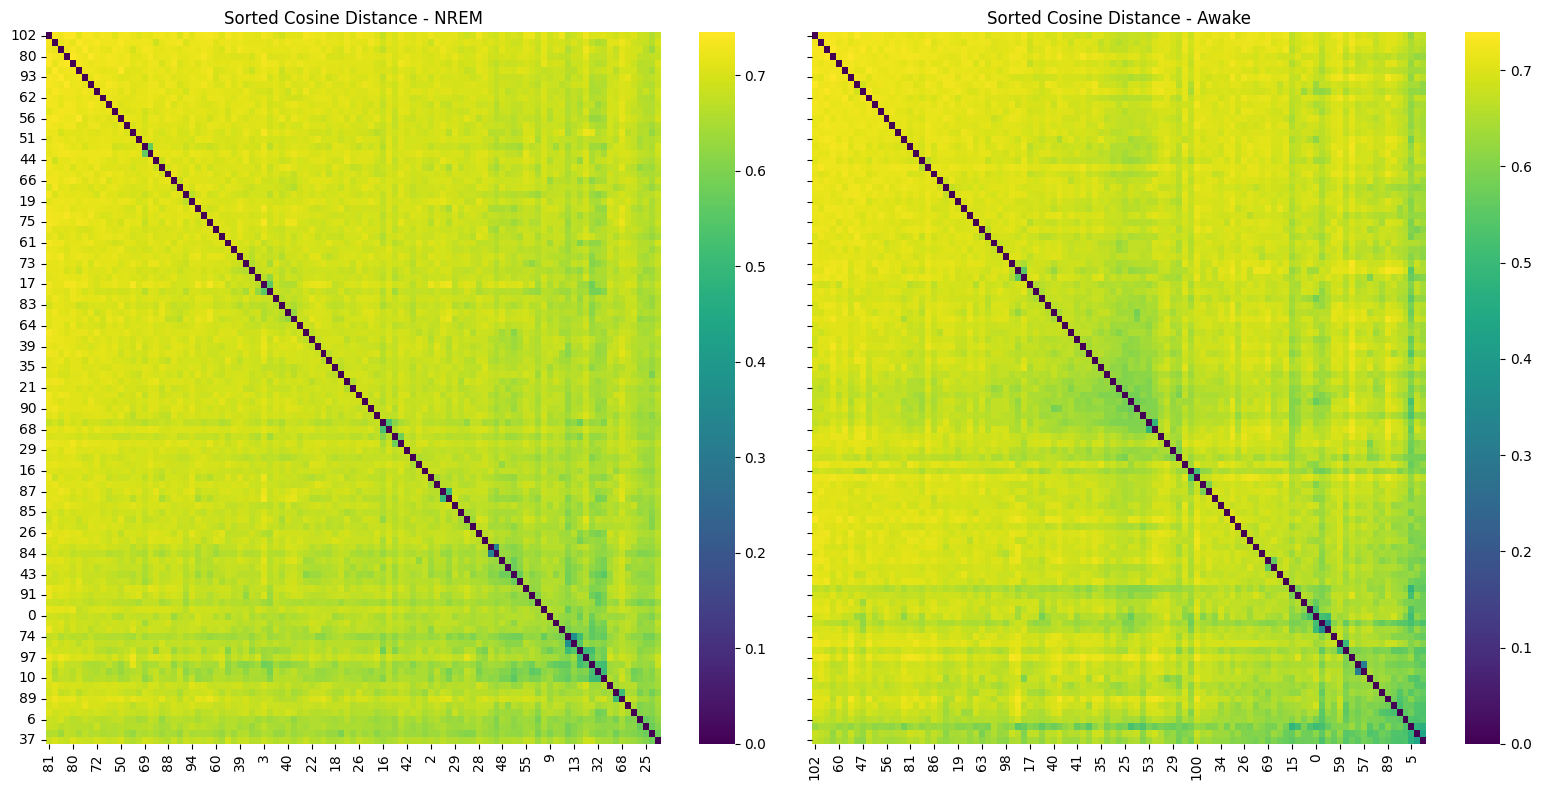

In [ ]:
sorted_cos_dist_nrem = clustering.sort_distance_matrix(cos_dist_nrem)
sorted_cos_dist_awake = clustering.sort_distance_matrix(cos_dist_awake)

# Now plot the sorted matrices using seaborn's heatmap function
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

sns.heatmap(sorted_cos_dist_nrem, ax=axs[0], cmap="viridis")
axs[0].set_title("Sorted Cosine Distance - NREM")

sns.heatmap(sorted_cos_dist_awake, ax=axs[1], cmap="viridis")
axs[1].set_title("Sorted Cosine Distance - Awake")

plt.tight_layout()

# saving the fig
fig.savefig(join(exp_path, "MC_sorted_cosine_dist.png"), dpi=300)

plt.show()

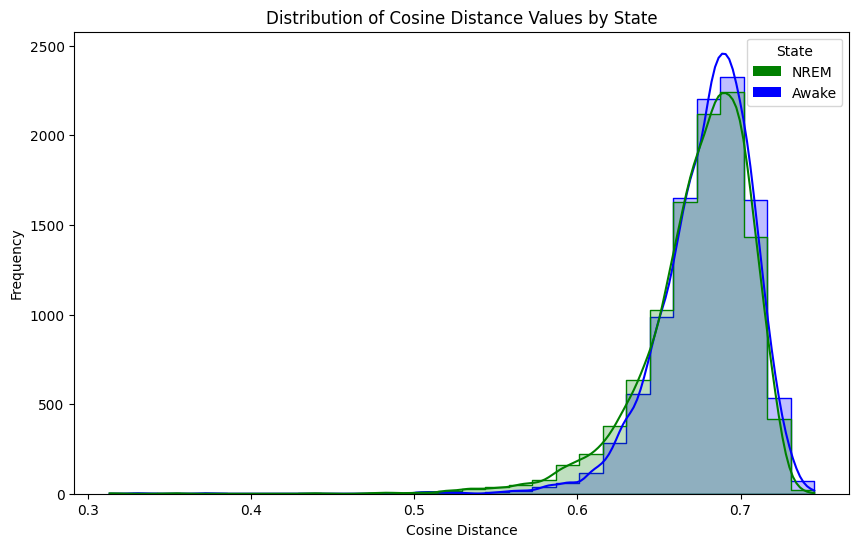

In [ ]:
# Flatten the matrices and remove the diagonal (self-distance) values
distance_values_nrem = cos_dist_nrem.values.flatten()
distance_values_nrem = distance_values_nrem[~np.isnan(distance_values_nrem)]  # Remove NaN values if any
distance_values_nrem = distance_values_nrem[distance_values_nrem != 0]  # Remove self-distances

distance_values_awake = cos_dist_awake.values.flatten()
distance_values_awake = distance_values_awake[~np.isnan(distance_values_awake)]  # Remove NaN values if any
distance_values_awake = distance_values_awake[distance_values_awake != 0]  # Remove self-distances

# Combine the distance values into a single array with an associated label array
distance_values_combined = np.concatenate([distance_values_nrem, distance_values_awake])
states_combined = ['NREM'] * len(distance_values_nrem) + ['Awake'] * len(distance_values_awake)

# Create DataFrame
distances_df = pd.DataFrame({
    'Cosine Distance': distance_values_combined,
    'State': states_combined
})

distances_df['State'] = distances_df['State'].astype('category')

# Plot
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    data=distances_df,
    x='Cosine Distance',
    hue='State',
    kde=True,
    element='step',
    bins=30,
    palette=['green', 'blue']  # Explicitly set the palette here to match your desired colors
)

plt.title('Distribution of Cosine Distance Values by State')
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')

# Create custom legend handles with colors matching the plot
legend_handles = [
    Patch(facecolor='green', label='NREM'),
    Patch(facecolor='blue', label='Awake')
]

# Use the custom handles to create the legend, ensuring colors match the plot
plt.legend(handles=legend_handles, title='State')

# Saving the figure
plt.savefig(join(exp_path, 'MC_distrib_cosine_distance_values.png'), dpi=300)

plt.show()